# 第7章 图像数据处理

- 本章将介绍如何对图像数据进行预处理使训练得到的神经网络模型尽可能小地被无关因素所影响；但与此同时，复杂的预处理过程可能导致训练效率的下降，为了减小预处理对于训练速度的影响，在本章中也将详细地介绍TensorFlow中多线程处理输入数据的解决方案

## 7.1 TFRecord输入数据格式

- TensorFlow提供了一种统一的格式来存储数据，这个格式就是TFRecord

### 7.1.1 TFRecord格式介绍

- TFRecord文件中的数据都是通过tf.train.Example Protocol Buffer的格式存储的；tf.train.Example中包含了一个从属性名称到取值的字典，其中属性名称为一个字符串，属性的取值可以为字符串（BytesList）、实数列表（FloatList）或者整数列表（Int64List）

### 7.1.2 TFRecord样例程序

- 以下程序给出了如何将MNIST输入数据转化为TFRecord的格式

In [1]:
import tensorflow as tf
from tensorflow.example.tutorials.mnist import input_data
import numpy as np

# 生成整数型的属性
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# 生成字符串型的属性
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

mnist = input_data.read_data_sets("/path/to/mnist/data", dtype=tf.unit8, one_hot=True)
images = mnist.train.images
labels = mnist.train.labels
pixels = images.shape[1]
num_examples = mnist.train.num_examples

# 输出TFRecord文件的地址
filename = '/path/to/output.tfrecords'
# 创建一个writer来写TFRecord文件
writer = tf.python_io.TFRecordWriter(filename)
for index in range(num_examples):
    # 将图像矩阵转化为一个字符串
    image_raw = images[index].tostring()
    # 将一个样例转化为Example Protocol Buffer，并将所有的信息写入这个数据结构
    example = tf.train.Example(features=tf.train.Features(feature={'pixels': _int64_features(pixels), 'label': _int64_feature(np.argmax(labels[index])), 'image_raw': _bytes_feature(image_raw)}))
    
    # 将一个Example写入TFRecord文件
    writer.write(example.SerializerToString())
writer.close()

ImportError: No module named example.tutorials.mnist

- 以下程序给出了如何读取TFRecord文件中的数据

In [2]:
import tensorflow as tf

# 创建一个reader来读取TFRecord文件中的样例
reader = tf.TFRecordReader()
# 创建一个队列来维护输入文件列表
filename_queue = tf.train.string_input_producer(['/path/to/output.tfrecords'])

# 从文件中读出一个样例，也可以使用read_up_to函数一次性读取多个样例
_, serialized_example = reader.read(filename_queue)
# 解析读入的一个样例，如果需要解析多个样例，可以用parse_example函数
features = tf.parse_single_example(serialized_example, features={
    # TensorFlow提供两种不同的属性解析方法；一种方法是tf.FixedLenFeature，这种方法解析的结果为一个Tensor；
    # 另一种方法是tf.VarLenFeature，这种方法得到的解析结果为SparseTensor，用于处理稀疏数据；
    # 这里解析数据的格式需要和上面程序写入数据的格式一致
    'image_raw': tf.FixedLenFeature([], tf.string), 
    'pixels': tf.FixedLenFeature([], tf.int64), 
    'label': tf.FixedLenFeature([], tf.int64),
})

# tf.decode_raw可以将字符串解析成图像对应的像素数组
image = tf.decode_raw(features['image_raw'], tf.uint8)
label = tf.cast(features['label'], tf.int32)
pixels = tf.cast(features['pixels'], tf.int32)

sess = tf.Session()
# 启动多线程处理输入数据
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

# 每次运行可以读取TFRecord文件中的一个样例，当所有样例都读完之后，在此样例中程序会重头读取
for i in range(10):
    print sess.run([image, label, pixels])

Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(string_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensor_slices(input_tensor).shuffle(tf.shape(input_tensor, out_type=tf.int64)[0]).repeat(num_epochs)`. If `shuffle=False`, omit the `.shuffle(...)`.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.Dataset.from_tensors(tensor).repeat(num_epochs)`.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
Use tf.cas

NotFoundError: /path/to/output.tfrecords; No such file or directory
	 [[node ReaderReadV2 (defined at <ipython-input-2-16b159140391>:9) ]]

Caused by op u'ReaderReadV2', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-16b159140391>", line 9, in <module>
    _, serialized_example = reader.read(filename_queue)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/io_ops.py", line 166, in read
    return gen_io_ops.reader_read_v2(self._reader_ref, queue_ref, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1027, in reader_read_v2
    queue_handle=queue_handle, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): /path/to/output.tfrecords; No such file or directory
	 [[node ReaderReadV2 (defined at <ipython-input-2-16b159140391>:9) ]]


## 7.2 图像数据处理

- 在之前的几章中多次使用到了图像识别数据集，然而在之前的章节中都是直接使用图像原始的像素矩阵，这一节将介绍图像的预处理过程，通过对图像的预处理，可以尽量避免模型受到无关因素的影响

### 7.2.1 TensorFlow图像处理函数

- TensorFlow提供了几类图像处理函数，在本节中将一一介绍这些图像处理函数

#### 图像编码处理

- 在之前的章节中提到一张RGB色彩模式的图像可以看成一个三维矩阵，矩阵中的每一个数表示了图像上不同位置，不同颜色的亮度，然而图像在存储时并不是直接记录这些矩阵中的数字，而是记录经过压缩编码之后的结果，所以要将一张图像还原成一个三维矩阵，需要解码的过程；TensorFlow提供了对JPEG和PNG格式图像的编码/解码函数

#### 图像大小调整

- 一般来说，网络上获取的图像大小是不固定的，但神经网络输入节点的个数是固定的，所以在将图像的像素作为输入提供给神经网络之前，需要先将图像的大小统一，这就是图像大小调整需要完成的任务

#### 图像翻转

- TensorFlow提供了一些函数来支持对图像的翻转
- 随机翻转训练图像是一种很常用的图像预处理方式

#### 图像色彩调整

- 和图像翻转类似，调整图像的亮度、对比度、饱和度和色相在很多图像识别应用中都不会影响识别结果，所以在训练神经网络模型时，可以随机调整训练图像的这些属性，从而使训练得到的模型尽可能小地受到无关因素的影响

#### 处理标注框

- 在很多图像识别的数据集中，图像中需要关注的物体通常会被标注框圈出来，TensorFlow提供了一些工具来处理标注框
- 和随机翻转图像、随机调整颜色类似，随机截取图像上有信息含量的部分也是一个提高模型健壮性（robustness）的一种方式

## 7.3 多线程输入数据处理框架

- 上一节介绍了使用TensorFlow对图像数据进行预处理的方法，虽然使用这些图像数据预处理的方法可以减小无关因素对图像识别模型效果的影响，但这些复杂的预处理过程也会减慢整个训练过程；为了避免图像预处理成为神经网络模型训练效率的瓶颈，TensorFlow提供了一套多线程处理输入数据的框架
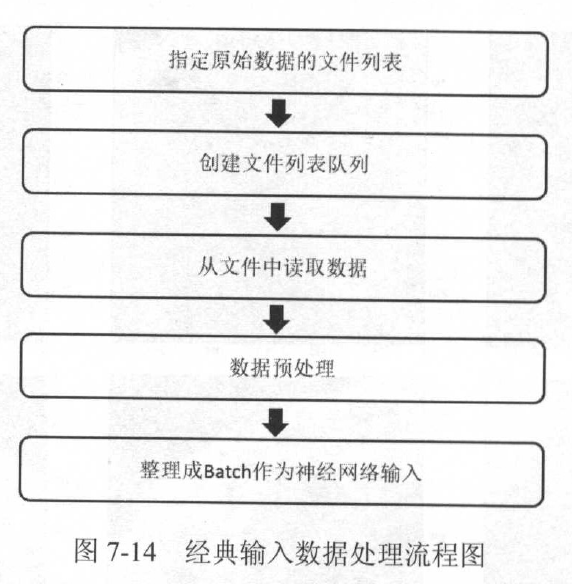

### 7.3.1 队列与多线程

- 在TensorFlow中，队列和变量类似，都是计算图上有状态的节点，其它的计算节点可以修改它们的状态；对于变量，可以通过赋值操作修改变量的取值，对于队列，修改队列状态的操作主要有Enqueue、EnqueueMany和Dequeue

In [3]:
import tensorflow as tf

# 创建一个先进先出队列，指定队列中最多可以保存两个元素，并指定类型为整数
q = tf.FIFOQueue(2, "int32")
# 使用enqueue_many函数来初始化队列中的元素；和变量初始化类似，在使用队列之前需要明确的调用这个初始化过程
init = q.enqueue_many(([0, 10], ))
# 使用Dequeue函数将队列中的第一个元素出队列，这个元素的值江北存在变量x中
x = q.dequeue()
# 将得到的值+1
y = x + 1
# 将加1后的值再重新加入队列
q_inc = q.enqueue([y])

with tf.Session() as sess:
    # 运行初始化队列的操作
    init.run()
    for _ in range(5):
        # 运行q_inc将执行数据出队列、出队的元素+1、重新加入队列的整个过程
        v, _ = sess.run([x, q_inc])
        # 打印出队元素的取值
        print v

0
10
1
11
2


- Tensorflow中提供了FIFOQueue和RandomShuffleQueue两种队列，前者是先进先出队列，后者会将队列中的元素打乱，每次出队列操作得到的是从当前队列所有元素中随机选择的一个

- 在TensorFlow中，队列不仅仅是一种数据结构，还是异步计算张量取值的一个重要机制，比如多个线程可以同时向一个队列中写元素，或者同时读取一个队列中的元素；TensorFlow提供了tf.Coordinator和tf.QueueRunner两个类来完成多线程协同的功能

## 7.4 数据集（Dataset）

- 除队列以外，TensorFlow还提供了一套更高层的数据处理框架；在新的框架中，每一个数据来源被抽象成一个“数据集”，开发者可以以数据集为基本对象，方便地进行batching、随机打乱（shuffle）等操作

### 7.4.1 数据集的基本使用方法

- 在数据集框架中，每一个数据集代表一个数据来源：数据可能来自一个张量，一个TFRecord文件，或者经过sharding的一系列文件，等等；由于训练数据通常无法全部写入内存中，从数据集中读取数据时需要使用一个迭代器（iterator）按顺序进行读取，数据集也是计算图上的一个节点

In [4]:
import tensorflow as tf

# 从一个数组创建数据集
input_data = [1, 2, 3, 5, 8]
dataset = tf.data.Dataset.from_tensor_slices(input_data)

# 定义一个迭代器用于遍历数据集；因为上面定义的数据集没有用placeholder作为输入参数，所以这里可以使用最简单的one_shot_iterator
iterator = dataset.make_one_shot_iterator()
# get_next()返回代表一个输入数据的张量
x = iterator.get_next()
y = x * x

with tf.Session() as sess:
    for i in range(len(input_data)):
        print sess.run(y)

1
4
9
25
64


- 从以上例子可以看到，利用数据集读取数据有三个基本步骤：1.定义数据集的构造方法，这个例子使用了tf.data.Dataset.from_tensor_slices()，表明数据集是从一个张量中构建的，如果数据集是从文件中构建的，则需要相应调用不同的构造方法；2.定义遍历器，这个例子使用了最简单的one_shot_iterator来遍历数据集，稍后将介绍更加灵活的initializable_iterator；3.使用get_next()方法从遍历器中读取数据张量，作为计算图其它部分的输入

- 在真实项目中，训练数据通常是保存在硬盘文件上的，比如在自然语言处理的任务中，训练数据通常是以每行一条数据的形式存在文本文件中，这时可以用TextLineDataset来更方便地读取数据

In [5]:
import tensorflow as tf

# 从文本文件创建数据集；假定每行文字是一个训练例子；注意这里可以提供多个文件
input_files = ["/path/to/input_file1", "/path/to/input_file2"]
dataset = tf.data.TextLineDataset(input_files)

# 定义迭代器用于遍历数据集
iterator = dataset.make_one_shot_iterator()
# 这里get_next()返回一个字符串类型的张量，代表文件中的一行
x = iterator.get_next()
with tf.Session() as sess:
    for i in range(3):
        print (sess.run(x))

NotFoundError: /path/to/input_file1; No such file or directory
	 [[node IteratorGetNext_1 (defined at <ipython-input-5-750032eb4951>:10) ]]

Caused by op u'IteratorGetNext_1', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-750032eb4951>", line 10, in <module>
    x = iterator.get_next()
  File "/Library/Python/2.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): /path/to/input_file1; No such file or directory
	 [[node IteratorGetNext_1 (defined at <ipython-input-5-750032eb4951>:10) ]]


- 在图像相关任务中，输入数据通常以TFRecord形式存储，这时可以用TFRecordDataset来读取数据；与文本文件不同，每一个TFRecord都有自己不同的feature格式，因此在读取TFRecord时，需要提供一个parser函数来解析所读取的TFRecord的数据格式

In [6]:
import tensorflow as tf

# 解析一个TFRecord的方法；record是从文件中读取的一个样例
def parser(record):
    # 解析读入的一个样例
    features = tf.parse_single_example(record, features={
        'feat1': tf.FixedLenFeature([], tf.int64), 
        'feat2': tf.FixedLenFeature([], tf.int64), })
    return features['feat1'], features['feat2']

# 从TFRecord文件创建数据集
input_files = ['/path/to/input_file1', '/path/to/input_file2']
dataset = tf.data.TFRecordDataset(input_files)

# map()函数表示对数据集中的每一条数据进行调用相应方法；使用TFRecordDataset读出的是二进制的数据，这里需要通过map()来调用parser()对二进制数据进行解析；类似地，map()函数也可以用来完成其他的数据预处理工作
dataset = dataset.map(parser)

# 定义遍历数据集的迭代器
iterator = dataset.make_one_shot_iterator()

# feat1, feat2是parser()返回的一维int64型张量，可以作为输入用于进一步的计算
feat1, feat2 = iterator.get_next()

with tf.Session() as sess:
    for i in range(10):
        f1, f2 = sess.run([feat1, feat2])

NotFoundError: /path/to/input_file1; No such file or directory
	 [[node IteratorGetNext_2 (defined at <ipython-input-6-63b43007dfc0>:22) ]]

Caused by op u'IteratorGetNext_2', defined at:
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Library/Python/2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Python/2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Python/2.7/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Library/Python/2.7/site-packages/tornado/ioloop.py", line 1064, in start
    handler_func(fd_obj, events)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Library/Python/2.7/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Library/Python/2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Library/Python/2.7/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Python/2.7/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2714, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2818, in run_ast_nodes
    if self.run_code(code, result):
  File "/Library/Python/2.7/site-packages/IPython/core/interactiveshell.py", line 2878, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-63b43007dfc0>", line 22, in <module>
    feat1, feat2 = iterator.get_next()
  File "/Library/Python/2.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 414, in get_next
    output_shapes=self._structure._flat_shapes, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1685, in iterator_get_next
    output_shapes=output_shapes, name=name)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/Library/Python/2.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

NotFoundError (see above for traceback): /path/to/input_file1; No such file or directory
	 [[node IteratorGetNext_2 (defined at <ipython-input-6-63b43007dfc0>:22) ]]


- 以上例子使用了最简单的one_shot_iterator来遍历数据集，在使用one_shot_iterator时，数据集的所有参数必须已经确定，因此one_shot_iterator不需要特别的初始化过程；如果需要用placeholder来初始化数据集，那就需要用到initializable_iterator

In [7]:
import tensorflow as tf

# 解析一个TFRecord的方法，与上面的例子相同，不再重复
def parser(record):
    ...
    
# 从TFRecord文件创建数据集，具体文件路径是一个placeholder，稍后再提供具体路径
input_files = tf.placeholder(tf.string)
dataset = tf.data.TFRecordDataset(input_files)
dataset = dataset.map(parser)

# 定义遍历dataset的initializable_iterator
iterator = dataset.make_initializable_iterator()
feat1, feat2 = iterator.get_next()

with tf.Session() as sess:
    # 首先初始化iterator，并给出input_files的值
    sess.run(iterator.initializer, feed_dict={input_files: ["/paht/to/input_file1", "/path/to/input_file2"]})
    
    # 遍历所有数据一个epoch；当遍历结束时，程序会抛出OutOfRangeError
    while True: # 用while True，因为在动态指定输入数据时，不同数据来源的数据量大小难以预知
        try:
            sess.run([feat1, feat2])
        except tf.errors.OutOfRangeError:
            break

SyntaxError: invalid syntax (<ipython-input-7-1eee247ed069>, line 5)